---
# **Project 2: Classification**
## Group 06
---


Team:
1. Ana Maria Accilio Villanueva                      (100%)
2. Kelvin Andrei Cahuana Condori                        (100%)
3. Yacira Nicol Campoverde San Martín                       (100%)
4. Johannes Albert Loayza Huaman                       (100%)



---

**PARTE 1**

##**1. Importación de librerias**


In [13]:
!pip install pyts

In [14]:
!pip install tsfresh

In [15]:
import pandas as pd
import numpy as np
import seaborn as sns
import h5py

from google.colab import drive
from pyts.transformation import ShapeletTransform

from sklearn.metrics import precision_score, f1_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.pipeline import make_pipeline
from sklearn.svm import LinearSVC

import matplotlib.pyplot as plt

## **2. Conexión con el dataset**

In [16]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [17]:
drive.mount('/content/drive')

path = '/content/drive/MyDrive/UNIVERSIDAD/SEMESTER 06/Machine Learning/P2/'

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## **3. Funciones auxiliares**

## Lectura de archivos

Esta función abre un archivos h5 y lee los datos etiquetados como 'x'. Si el archivo también contiene datos etiquetados como 'y', los lee opcionalmente. Luego, la función devuelve estos datos.

In [18]:
def readH5File(filename):
  with h5py.File(path + filename, 'r') as f:
    x = f['x'][:]
    if 'y' in f:
      y = f['y'][:]
      return x, y
    return x

filename = 'train.h5'
x_data, y_data = readH5File(filename)
print("Datos de x:", x_data)
if y_data is not None:
    print("Datos de y:", y_data)
else:
    print("No hay datos de y en el archivo.")

Datos de x: [[[-5.859375e-03 -1.141357e-02 -1.077271e-02 ... -1.989746e-02
   -2.163696e-02 -1.885986e-02]]

 [[ 2.380371e-03  5.126953e-03  5.737305e-03 ... -3.997803e-03
   -5.981445e-03 -7.659912e-03]]

 [[ 5.807495e-02  1.220398e-01  1.083069e-01 ... -1.315308e-02
   -1.412964e-02 -1.824951e-02]]

 ...

 [[ 1.516724e-02  3.179932e-02  2.697754e-02 ... -2.716064e-03
   -8.239746e-04  3.051758e-04]]

 [[ 2.532959e-03  5.218506e-03  3.570557e-03 ... -3.692627e-03
   -3.356934e-03 -3.479004e-03]]

 [[-2.990723e-03 -4.119873e-03  3.662109e-04 ... -6.103516e-05
   -9.552002e-03 -1.931763e-02]]]
Datos de y: [0 1 0 0 0 1 0 0 0 0 1 0 1 0 0 1 0 1 0 0 0 1 0 0 0 0 1 0 1 0 1 0 0 0 0 0 0
 0 0 0 1 0 0 0 1 1 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 1 0 0 0 1 0 0 0 0 1 0 0
 1 0 0 1 0 0 0 0 1 0 0 0 0 0 0 1 1 0 0 0 1 0 0 0 0 0 0 0 0 1 1 1 0 1 0 0 1
 0 1 1 0 0 0 0 1 0 0 0 1 0 0 0 0 0 0 1 0 0 1 0 0 0 1 0 1 0 0 0 1 0 1 1 1 1
 0 0 0 0 0 1 0 0 1 0 1 1 0 1 0 0 1 0 0 0 0 0 0 0 0 0 0 1 0 0 1 0 1 0 0 1 0
 0 0 0 1 0 1 

## Matriz de confusión

Genera y muestra una matriz de confusión para evaluar el rendimiento de un modelo de clasificación.

In [19]:
def confusionMatrix(y_pred, y_test, type_label):
  labels = ['no predisposition to alcoholism', 'predisposition to alcoholism']
  matrix = confusion_matrix(y_test, y_pred).astype('float')
  matrix = matrix / matrix.sum(axis=1)[:, np.newaxis]
  df_matrix = pd.DataFrame(matrix, index=labels, columns=labels)

  sns.heatmap(df_matrix, annot=True, cbar=False, cmap="Greens")
  plt.title("Confusion Matrix " + type_label)
  plt.xlabel("Predicted")
  plt.ylabel("Actual")
  plt.tight_layout()
  plt.show()

## Métricas

Calcula métricas de evaluación del rendimiento de un modelo de clasificación.

In [20]:
def getMetrics(y_test, y_pred):
  targets = ['no predisposition to alcoholism', 'predisposition to alcoholism']

  precision = precision_score(y_test, y_pred, average=None)
  f1 = f1_score(y_test, y_pred, average=None)

  report = classification_report(y_test, y_pred, target_names=targets)
  print("My Model Metrics:")
  print(report)

  results = {}
  for i, name in enumerate(targets):
    results[name] = {
      "Precision": precision[i],
      "F1-Score": f1[i]
    }

  return results

##**4. Análisis de las señales**

*En el conjunto de datos contiene dos clases de datos de señales: Alcohólicas y normales. La base es recopilada en base a 122 sujetos y se realiza 120 ensayos de cada sujeto. A continuación, se muestra ambas señales:*

(204, 1, 18530)


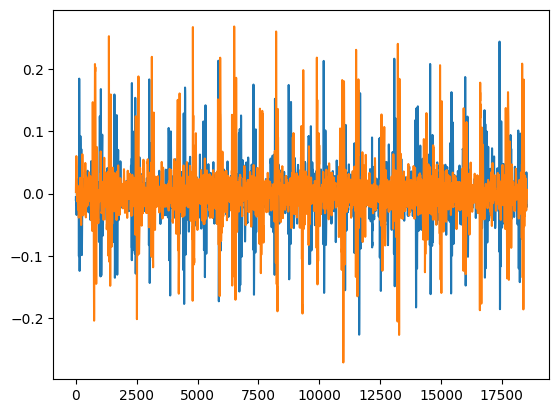

In [21]:
x_train, y_train = readH5File('/train.h5')
x_test = readH5File('/test.h5')

print(x_train.shape)
x_train = x_train.squeeze(axis=1)
x_test = x_test.squeeze(axis=1)
plt.plot(x_train[0][:])
plt.plot(x_train[1][:])
plt.show()


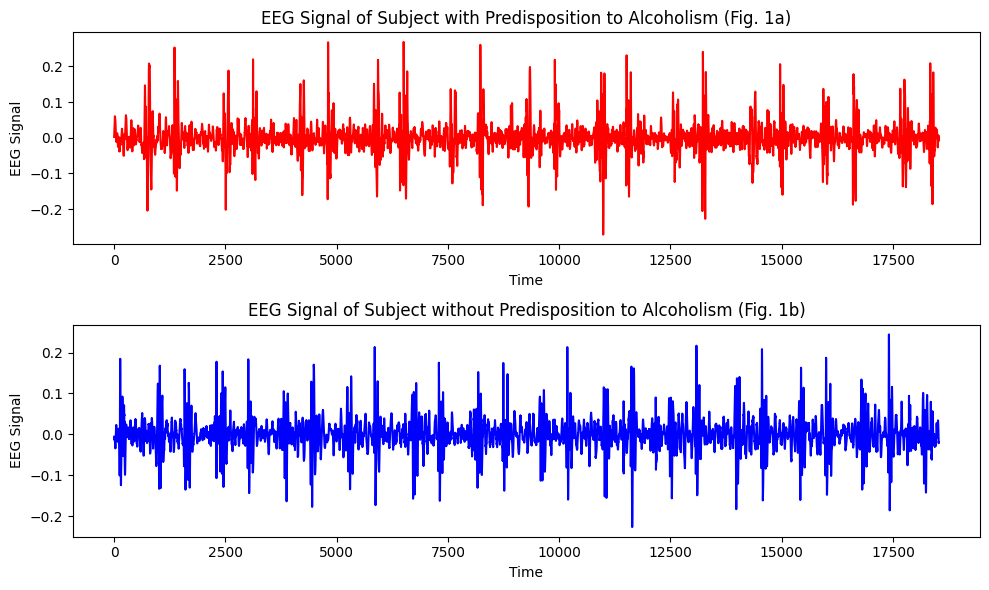

In [22]:
alcoholic_index = np.where(y_train == 1)[0][0]
non_alcoholic_index = np.where(y_train == 0)[0][0]

# Señal EEG de un sujeto con predisposición al alcoholismo
plt.figure(figsize=(10, 6))
plt.subplot(2, 1, 1)
plt.plot(x_train[alcoholic_index], color='r')
plt.title('EEG Signal of Subject with Predisposition to Alcoholism (Fig. 1a)')
plt.xlabel('Time')
plt.ylabel('EEG Signal')

# Señal EEG de un sujeto sin predisposición al alcoholismo
plt.subplot(2, 1, 2)
plt.plot(x_train[non_alcoholic_index], color='b')
plt.title('EEG Signal of Subject without Predisposition to Alcoholism (Fig. 1b)')
plt.xlabel('Time')
plt.ylabel('EEG Signal')

plt.tight_layout()
plt.show()

Análisis con Descomposición (EMD) Lo usamos para analizar las caraactersiticas, sin la necesidad de suponer su linealidad. Asimismo, evaluaremos la descomposición de las señales en varios IMFs (Componentes oscilatorios de la señal original) Tomando en cuenta sus escalas de tiempo y frecuencias.

### **Descomposición de las señales**

---



In [23]:
!pip install EMD-signal

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 74.6/74.6 kB 1.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 82.1/82.1 kB 5.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.8/56.8 kB 6.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 4.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 11.9 MB/s eta 0:00:00


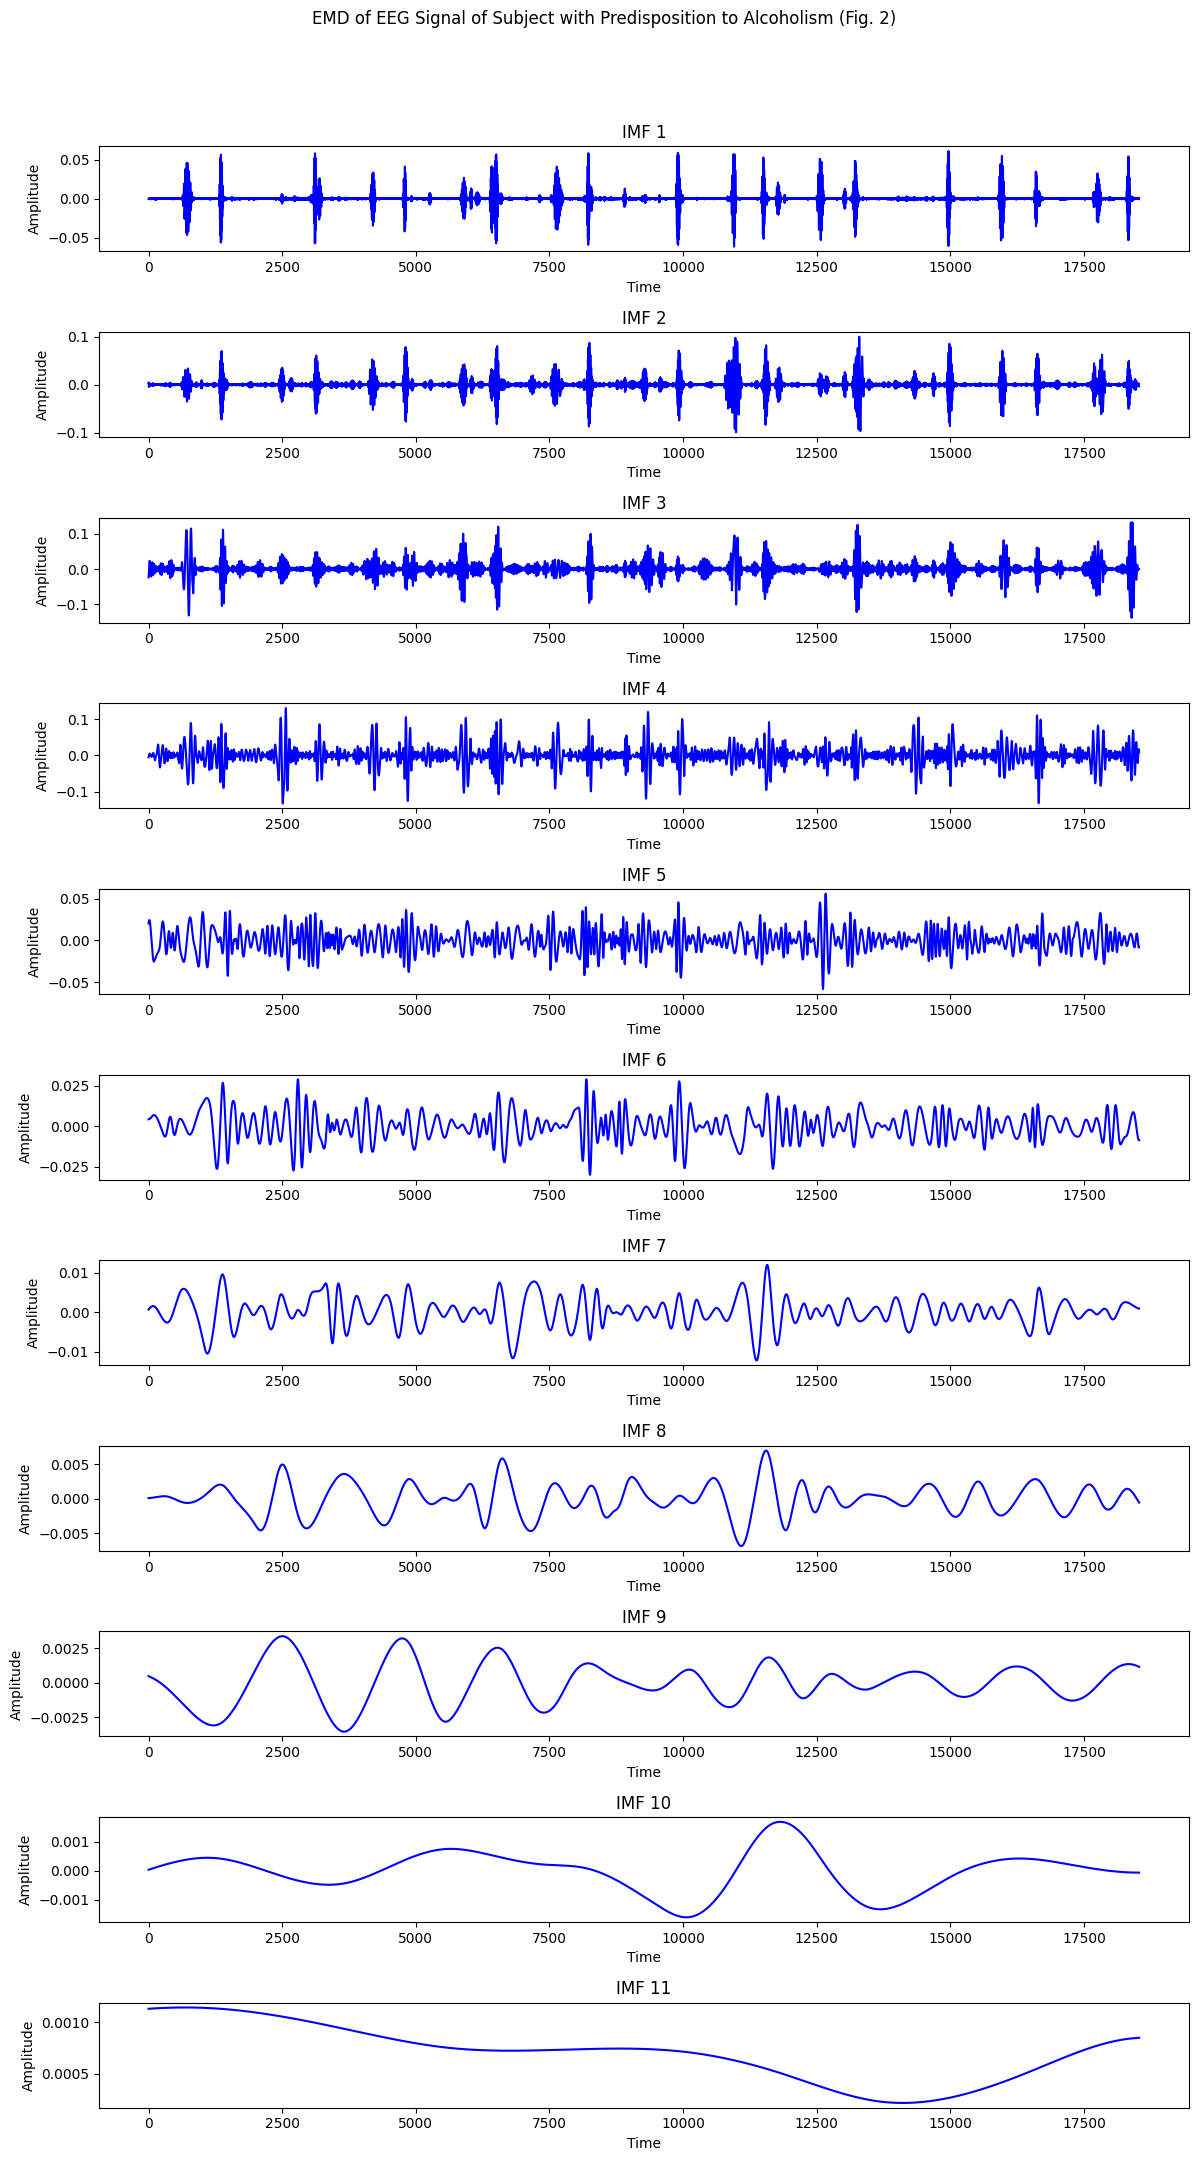

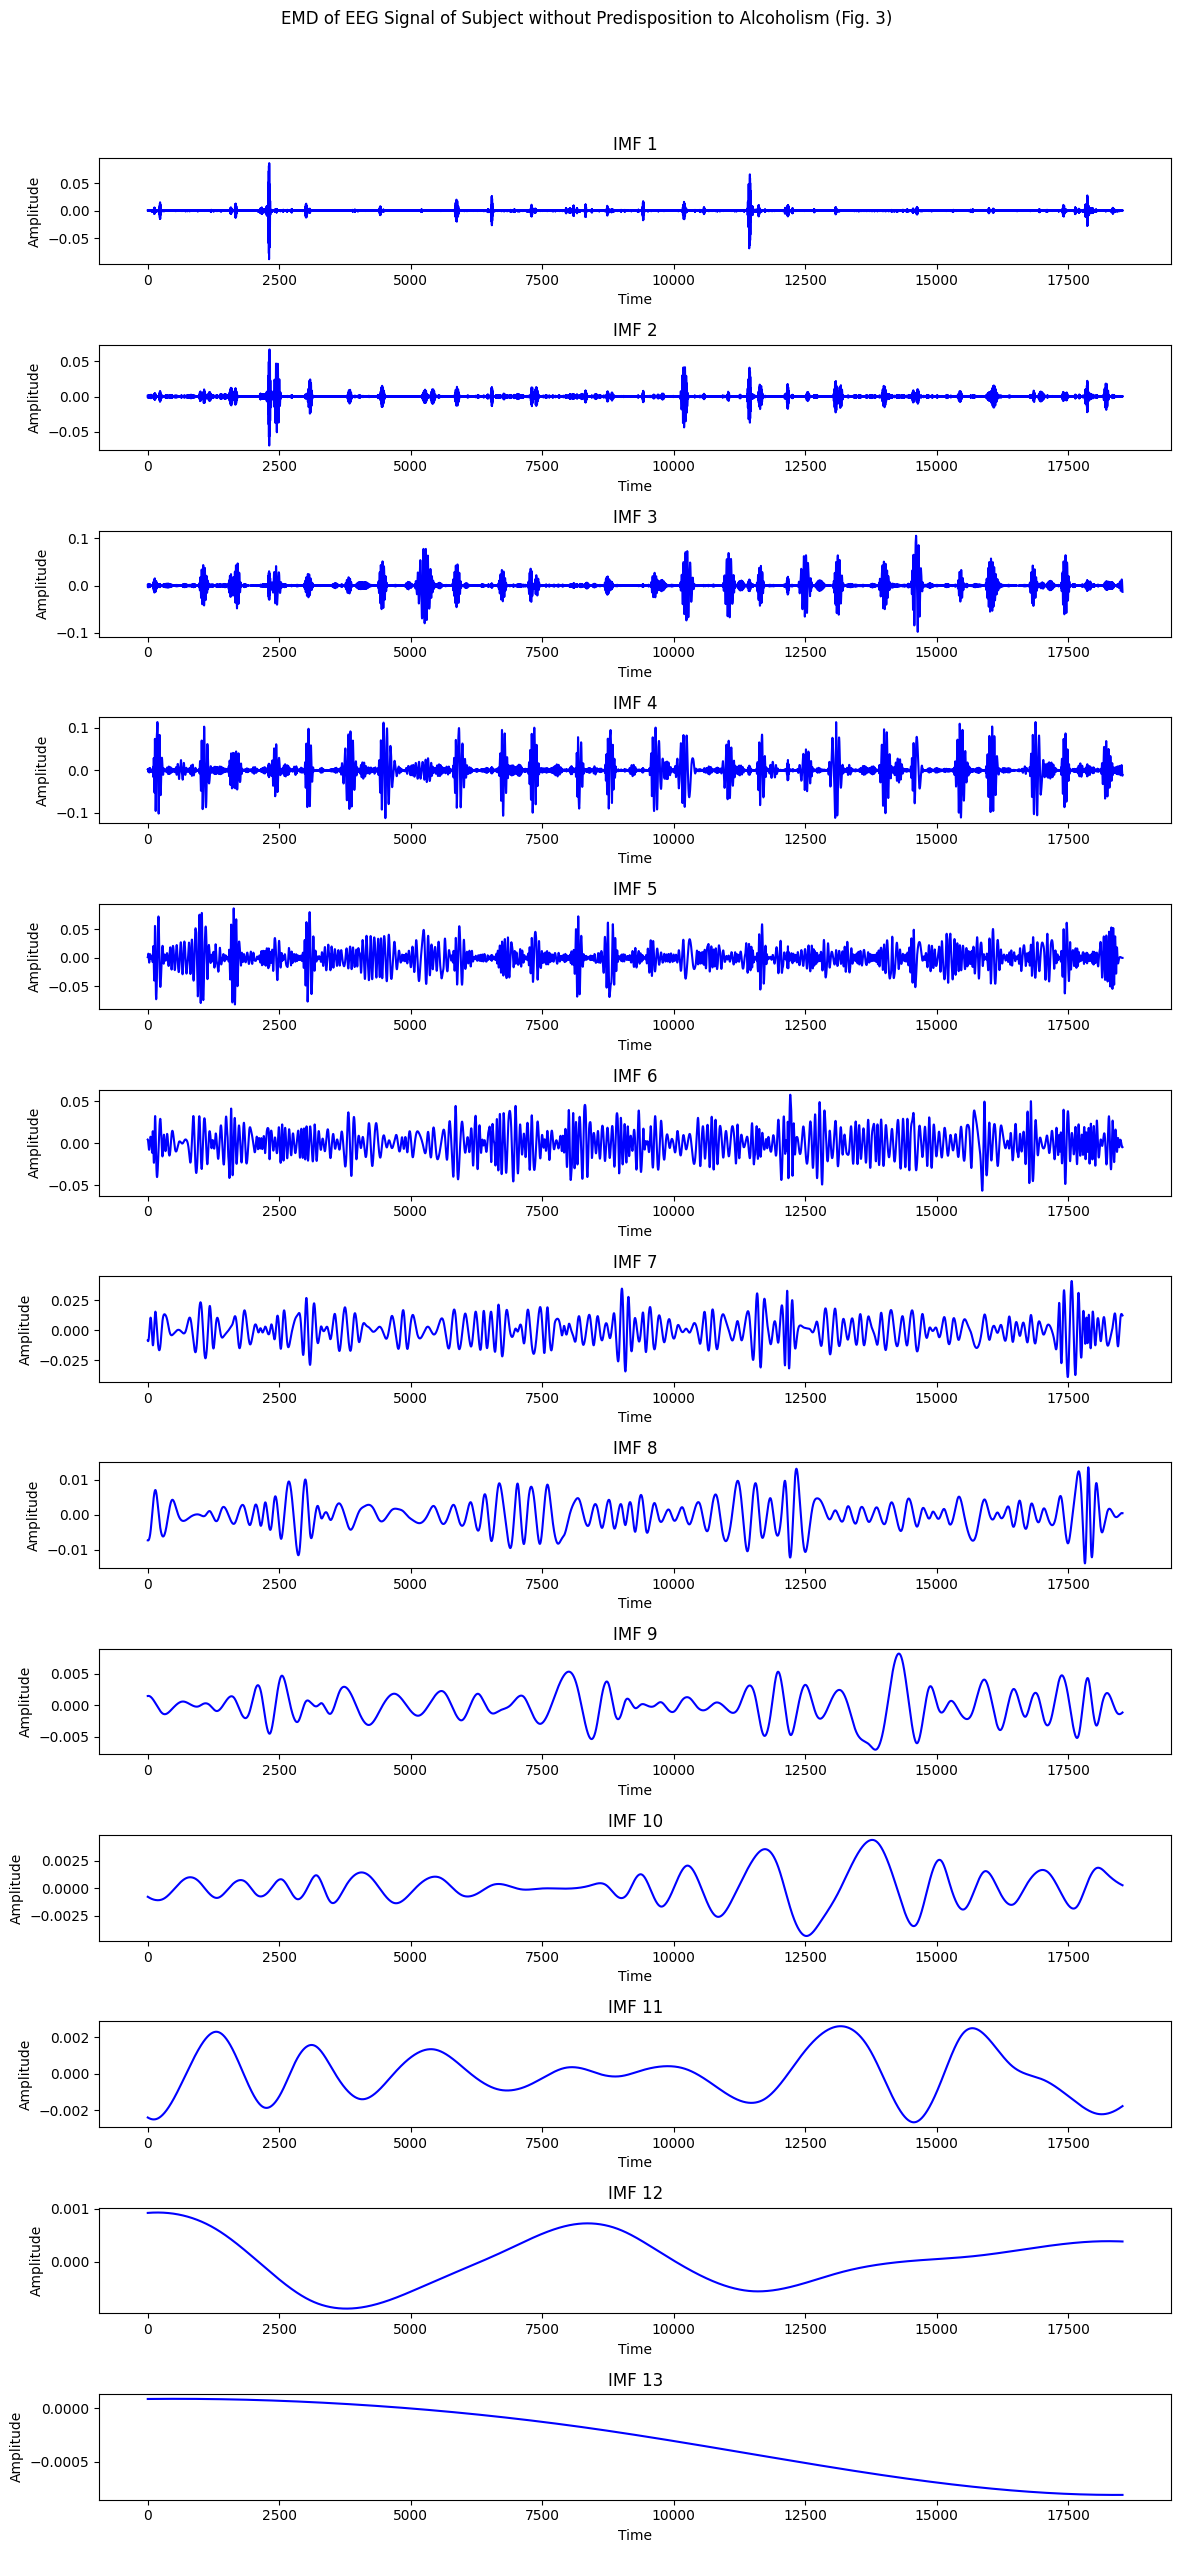

In [24]:
from PyEMD import EMD
alcoholic_signal = x_train[alcoholic_index]
non_alcoholic_signal = x_train[non_alcoholic_index]
def plot_emd(signal, title):
    emd = EMD()
    imfs = emd(signal)
    num_imfs = imfs.shape[0]

    plt.figure(figsize=(12, 2 * num_imfs))
    plt.suptitle(title)
    for i in range(num_imfs):
        plt.subplot(num_imfs, 1, i + 1)
        plt.plot(imfs[i], 'g' if "Alcoholic" in title else 'b')
        plt.title(f'IMF {i+1}')
        plt.xlabel('Time')
        plt.ylabel('Amplitude')
    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()

# Alcohólica
plot_emd(alcoholic_signal, 'EMD of EEG Signal of Subject with Predisposition to Alcoholism (Fig. 2)')

# Normal
plot_emd(non_alcoholic_signal, 'EMD of EEG Signal of Subject without Predisposition to Alcoholism (Fig. 3)')

##**5. Modelos**

-----
## **5.1. Regresión Logística**
----




Utilizar un modelo de Regresión Logística para analizar datos de nuestro dataset en el contexto de la predisposición genética al alcoholismo es recomendable por varias razones:

* **Clasificación Binaria:** La Regresión Logística es adecuada para problemas de clasificación binaria, donde el objetivo es distinguir entre dos clases. En este estudio, los dos grupos son 'predisposición al alcoholismo' y la 'no predisposición al alcoholismo'. Además, puede modelar directamente la probabilidad de que un registro de nuestro dataset pertenezca a una de estas clases.

* **Interpretabilidad:** La Regresión Logística proporciona coeficientes que indican la importancia y la dirección de cada característica (por ejemplo, las características de la señal EEG de diferentes electrodos). Esta interpretabilidad puede ayudar a entender qué electrodos específicos o regiones del cerebro son más indicativos de una predisposición al alcoholismo.

* **Manejo de datos de alta dimensionalidad:** Aunque los datos de nuestro dataset son de alta dimensionalidad (con múltiples electrodos y puntos de tiempo), la Regresión Logística puede manejar entradas de alta dimensionalidad, especialmente si se emplean técnicas de reducción de dimensionalidad (como PCA) o métodos de selección de características.

* **Regularización:** La Regresión Logística admite regularización (por ejemplo, regularización L1 y L2), lo que puede prevenir el sobreajuste en presencia de muchas características y ayudar a manejar la complejidad del modelo.

* **Robustez:** La Regresión Logística puede ser robusta frente a la multicolinealidad y características correlacionadas, lo cual es importante en datos de nuestro dataset donde las señales de electrodos cercanos pueden estar correlacionadas.

In [25]:
class LogisticRegression:
  def __init__(self, alpha=0.05, epochs=10000, epsilon=0.01):
    self.alpha = alpha
    self.epochs = epochs
    self.epsilon = epsilon
    self.weights = None

  def H(self, x):
    return np.dot(x, self.weights)

  def S(self, x):
    return 1 / (1 + np.exp(-self.H(x)))

  def Loss(self, y, y_aprox):
    y_aprox = np.clip(y_aprox, self.epsilon, 1 - self.epsilon)
    s = -np.mean(y * np.log(y_aprox) + (1 - y) * np.log(1 - y_aprox))
    return s

  def Derivatives(self, x, y):
    y_approx = self.S(x)
    n = len(y)

    return np.matmul((y - y_approx), -x) / n

  def Update(self, derivatives):
    self.weights = self.weights - self.alpha * derivatives

  def Train(self, x, y):
    np.random.seed(11)
    loss_vec = []
    self.weights = np.random.rand(x.shape[1])

    for i in range(self.epochs):
      y_approx = self.S(x)
      loss_value = self.Loss(y, y_approx)
      dw_value = self.Derivatives(x, y)

      self.Update(dw_value)
      loss_vec.append(loss_value)

    return dw_value, loss_vec

  def Predict(self, x):
    probabilities = self.S(x)
    return np.round(probabilities)

  def Test(self, x_test, y_test):
    n = len(y_test)
    TP = 0
    TN = 0
    FP = 0
    FN = 0

    predVector = []
    for i in range(n):
      pred = self.S(x_test[i], self.weights);
      predVector.append(pred)
      predRounded = round(pred)

      if predRounded == 1 and y_test[i] == 1:
        TP += 1
      elif predRounded == 0 and y_test[i] == 0:
        TN += 1
      elif predRounded == 1 and y_test[i] == 0:
        FP += 1
      elif predRounded == 0 and y_test[i] == 1:
        FN += 1

    TP_percent = TP / n * 100;
    TN_percent = TN / n * 100;
    FP_percent = FP / n * 100;
    FN_percent = FN / n * 100;
    accuracy_percent = TP + TN / n * 100;

    print(f"True Positives (TP): {TP_percent:.2f}%")
    print(f"True Negatives (TN): {TN_percent:.2f}%")
    print(f"False Positives (FP): {FP_percent:.2f}%")
    print(f"False Negatives (FN): {FN_percent:.2f}%")
    print(f"Accuracy: {accuracy_percent:.2f}%")


###  **Extracting features**


Para este proyecto, hemos utilizado la técnica ROCKET para extraer características de una serie temporal, principalmente porque no es tan costosa computacionalmente y ofrece buenos resultados en la extracción de características. Cabe resaltar que también hemos probado otras opciones, como el uso de la librería TsFresh y la técnica ShapeletTransform, pero las descartamos por ser muy costosas computacionalmente. Además, probamos la técnica BOOS, pero esta tampoco ofreció resultados satisfactorios.

In [26]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from pyts.transformation import ROCKET

Reducción de la dimesionalidad

In [27]:
X, Y = readH5File('train.h5')
X_test = readH5File('test.h5')
X = X.squeeze(axis=1)
X_test = X_test.squeeze(axis=1)

Split

In [28]:
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.3, random_state=42)

**Normaliza x_train y x_test antes de aplicar ROCKET.**

In [29]:
scaler = StandardScaler()
x_train_normalized = scaler.fit_transform(x_train)
x_test_normalized = scaler.fit_transform(x_test)

**ROCKET: Random Convolutional Kernel Transform**

A diferencia de otros métodos de extracción de características que tienen un alto costo computacional, este método nos ofrece una forma más sencilla y menos costosa de obtener características.

* Con ROCKET, transformamos las series temporales de entrada para la extracción de características mediante núcleos convolucionales aleatorios.

* Las convoluciones implican productos escalares deslizantes entre un núcleo convolucional y una serie temporal de entrada. La salida convolucional refleja la fuerza de la coincidencia entre el núcleo y la serie temporal de entrada en cada momento.

* La convolución representa un mecanismo para capturar diversas características en series temporales, lo que es la base de la eficacia de esta técnica.

* Esta técnica utiliza más de 10,000 núcleos convolucionales aleatorios, que varían en longitud, peso, sesgo, etc.

In [30]:
rocket = ROCKET()
rocket.fit(x_train_normalized)
x_train_transformed = rocket.transform(x_train_normalized)
x_test_transformed = rocket.transform(x_test_normalized)

Modelo de regresión logística para la clasificación de datos binarios. Los parámetros del modelo, como la tasa de aprendizaje (alpha) con **0.8**, el número de iteraciones de entrenamiento (epochs) **1200**, y el criterio de convergencia (epsilon) siendo **1e-4**, se configuran para ajustar los pesos del modelo dura
nte el entrenamiento.

In [31]:
model = LogisticRegression(alpha=0.8, epochs=1200, epsilon=1e-4)
dW, loss = model.Train(x_train_transformed, y_train)

y_pred = model.Predict(x_test_transformed)

print(y_pred, y_test)

<ipython-input-25-2ea724478ec1>:12: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(-self.H(x)))


[1. 1. 1. 1. 0. 1. 0. 1. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 1. 1. 0. 1. 0. 0. 0. 0. 0. 0.] [1 0 0 0 1 1 1 1 0 0 0 0 0 0 1 0 0 0 0 1 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0
 1 1 0 1 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 0 0 1 0 0 0]


### **Classification Metrics**

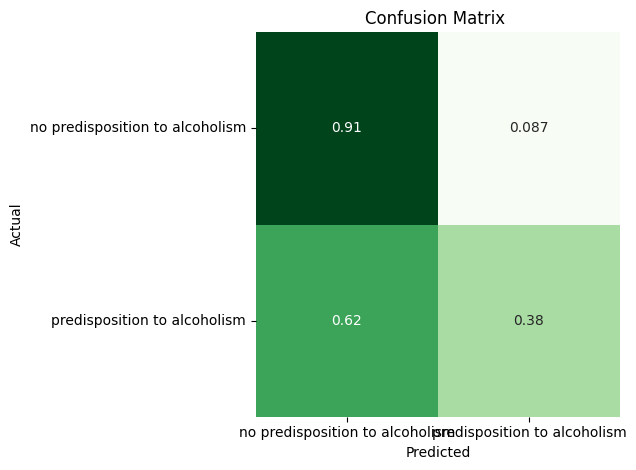

In [32]:
confusionMatrix(y_pred, y_test, type_label='')

In [33]:
results = getMetrics(y_test, y_pred)

My Model Metrics:
                                 precision    recall  f1-score   support

no predisposition to alcoholism       0.81      0.91      0.86        46
   predisposition to alcoholism       0.60      0.38      0.46        16

                       accuracy                           0.77        62
                      macro avg       0.70      0.64      0.66        62
                   weighted avg       0.75      0.77      0.76        62

